In [1]:
# distribution of responses

# inter-annotator consistency

# find an example with a consensus low rating

# find an example with a consensus high rating

# find a controversial example

# run the reward model on each of these examples

In [1]:
import os
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
csv_files = glob.glob(os.path.join('../musicgpt-user-study/*.csv'), recursive=True)
dfs = []
for csv in csv_files:
    dfs.append(pd.read_csv(csv))

df = pd.concat(dfs, axis=0, ignore_index=True)
# Take out neutral examples
df = df[df['Answer.preference'] != 2]
# Make sure we're looking at the processed MIDI clips
df = df.applymap(lambda value: str(value).replace('prompt', 'prompt-processed'))
# Shuffle rows
# df.sample(frac=1, random_state=0)
feedback_data = df.to_numpy()
eda_df = df.copy()

In [3]:
# Make preferences floats
eda_df['Answer.preference'] = eda_df['Answer.preference'].astype(float)
# Rescale preferences
eda_df['Answer.preference'] = eda_df['Answer.preference'].apply(lambda x: (x - 1) / 2)

In [4]:
val_csv_files = glob.glob(os.path.join('../harmonization-1.csv'), recursive=True)

val_df = pd.read_csv(val_csv_files[0])
val_df = val_df.applymap(lambda value: str(value).replace('harmony', 'harmony-processed'))
val_feedback_data = val_df.to_numpy()

In [5]:
idx = 0
print(eda_df.iloc[idx]['Input.recording_0_url'])

https://p-lambda.github.io/musicgpt-user-study/prompt-processed/system3/42-clip-v0.mp3


In [6]:
unique_comparisons = list(set(zip(eda_df['Input.recording_0_url'], eda_df['Input.recording_1_url'])))

In [7]:
comparison = ('https://p-lambda.github.io/musicgpt-user-study/prompt-processed/system1/27-clip.mp3',
  'https://p-lambda.github.io/musicgpt-user-study/prompt-processed/system4/27-clip-v0.mp3')

eda_df[(eda_df['Input.recording_0_url'] == comparison[0]) & (eda_df['Input.recording_1_url'] == comparison[1])]['Answer.preference']

742    1.0
743    0.0
Name: Answer.preference, dtype: float64

In [8]:
mean_preferences = {}
for comparison in unique_comparisons:
    mean_preferences[comparison] = eda_df[(eda_df['Input.recording_0_url'] == comparison[0]) & (eda_df['Input.recording_1_url'] == comparison[1])]['Answer.preference'].values.mean()

In [9]:
# Interesting find, ground truth only wins about 70-75% of the time
eda_df[eda_df['Input.recording_1_url'].str.contains('system1')]['Answer.preference'].value_counts()

1.0    199
0.0     61
Name: Answer.preference, dtype: int64

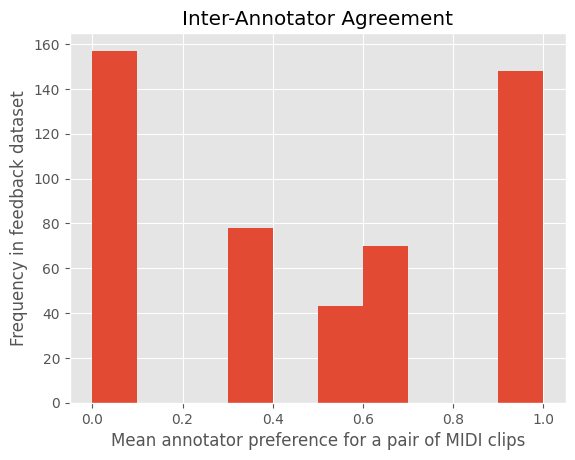

In [10]:
# Extract the values into a list
mean_preferences_list = list(mean_preferences.values())

plt.hist(mean_preferences_list, bins='auto')  # 'auto' automatically determines the number of bins
plt.title('Inter-Annotator Agreement')
plt.xlabel('Mean annotator preference for a pair of MIDI clips')
plt.ylabel('Frequency in feedback dataset')
# plt.show()
plt.savefig('../figures/inter-annotator-agreement.png', dpi=300, bbox_inches = "tight")

In [11]:
def calculate_win_rate(df):
    # Count the total number of occurrences of each url
    total_counts = df['Input.recording_0_url'].append(df['Input.recording_1_url']).value_counts()

    # Count the number of times each url is preferred
    prefer_counts_0 = df[df['Answer.preference'] == 0]['Input.recording_0_url'].value_counts()
    prefer_counts_1 = df[df['Answer.preference'] == 1]['Input.recording_1_url'].value_counts()

    # Combine the counts for urls that were preferred when in either column
    prefer_counts = prefer_counts_0.add(prefer_counts_1, fill_value=0)

    # Calculate win rate
    win_rate = prefer_counts / total_counts

    # Replace NaN values with 0
    win_rate = win_rate.fillna(0.0)

    # Convert to dictionary
    win_rate_dict = win_rate.to_dict()

    return win_rate_dict

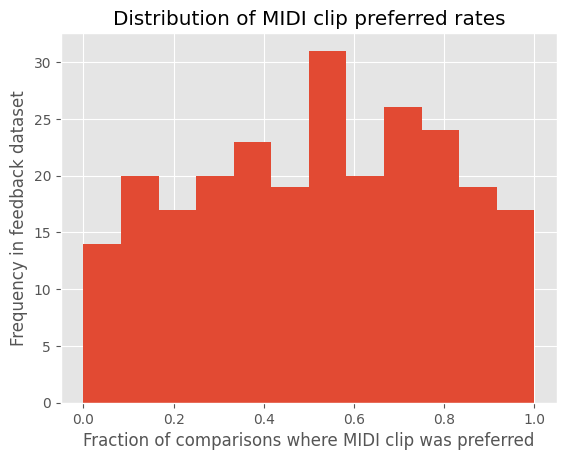

In [12]:
win_rate_dict = calculate_win_rate(eda_df)

# Extract win rates from the dictionary
win_rates = list(win_rate_dict.values())

# Create a histogram
plt.hist(win_rates, bins=12)

# Set the title and labels
plt.title('Distribution of MIDI clip preferred rates')
plt.xlabel('Fraction of comparisons where MIDI clip was preferred')
plt.ylabel('Frequency in feedback dataset')

# Show the plot
# plt.show()
plt.savefig('../figures/feedback-distribution.png', dpi=300, bbox_inches = "tight")

In [13]:
winners = [key for key, value in win_rate_dict.items() if value > 0.5]

# Audit Reward Model

In [14]:
# Load the reward model
import torch
from models.reward import RewardModule
from models.seq2seq import Seq2SeqModule

import torch.nn.functional as F

# Dataset dependencies
import pickle
from input_representation import InputRepresentation
from vocab import RemiVocab, DescriptionVocab
from constants import (
  PAD_TOKEN, BOS_TOKEN, EOS_TOKEN, BAR_KEY, POSITION_KEY,
  TIME_SIGNATURE_KEY, INSTRUMENT_KEY, CHORD_KEY,
  NOTE_DENSITY_KEY, MEAN_PITCH_KEY, MEAN_VELOCITY_KEY, MEAN_DURATION_KEY
)

/Users/npb/miniconda3/envs/figaro/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Load checkpoint
checkpoint_path = '../results/reward_9_last.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load model
model = RewardModule(backbone_checkpoint='../checkpoints/baseline.ckpt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print('done')

done


## Distribution of rewards on the feedback dataset

In [16]:
# Load some data
feedback_data = df.to_numpy()

datamodule = model.get_datamodule(
    feedback_data=feedback_data,
    midi_root_dir='../',
    vae_module=None,
    batch_size=128, 
    num_workers=1, 
    pin_memory=True
)

datamodule.setup()

FeedbackDataModule Setup: Train split 1102; Validation split 129; Test split 64


In [17]:
dl = datamodule.train_dataloader()

In [18]:
steps_per_epoch = 100

In [19]:
reward_list = []
logits_list = []

In [20]:
high_reward_files = []

In [156]:
with torch.no_grad():
    for step, batch in enumerate(dl):
        if step >= steps_per_epoch:
            break

        # Extract the batch
        x_0 = batch['input_ids_0']
        bar_ids_0 = batch['bar_ids_0']
        position_ids_0 = batch['position_ids_0']
        x_1 = batch['input_ids_1']
        bar_ids_1 = batch['bar_ids_1']
        position_ids_1 = batch['position_ids_1']
        preference = batch['preference']  

        rewards_0 = model(x_0, bar_ids=bar_ids_0, position_ids=position_ids_0)
        rewards_1 = model(x_1, bar_ids=bar_ids_1, position_ids=position_ids_1)

        for i in range(len(rewards_0)):
            if (rewards_0[i] > 1):
                high_reward_files.append(batch['file_0'][i])
            if (rewards_1[i] > 1):
                high_reward_files.append(batch['file_1'][i])

        logits = rewards_1 - rewards_0

        reward_list.extend(rewards_0.tolist())
        reward_list.extend(rewards_1.tolist())
        logits_list.extend(logits.tolist())

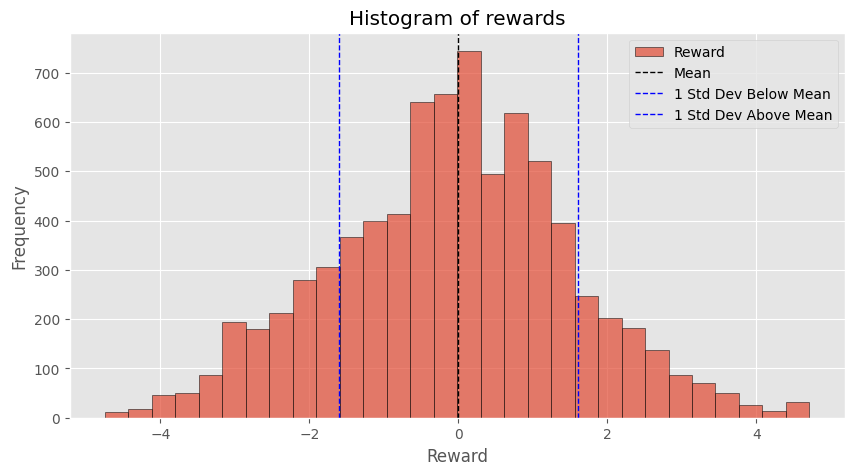

Mean reward:  0
Standard deviation of reward:  1.6011949919088275


<Figure size 640x480 with 0 Axes>

In [167]:
reward_arr = np.array(reward_list)

# Calculate mean and standard deviation
mean = np.mean(reward_arr)
std_dev = np.std(reward_arr)

# Calculate mean and standard deviation
mean = np.mean(reward_arr)
std_dev = np.std(reward_arr)

# Create the histogram
plt.figure(figsize=(10, 5))
plt.hist(reward_arr, bins=30, alpha=0.7, label='Reward', edgecolor='black')

# Add lines for the mean and one standard deviation above and below the mean
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev Below Mean')
plt.axvline(mean + std_dev, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev Above Mean')

# Add labels and legend
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of rewards')
plt.grid(True)
plt.show()

print('Mean reward: ', mean)
print('Standard deviation of reward: ', std_dev)

# plt.savefig('../figures/feedback-reward-histogram.png', dpi=300, bbox_inches = "tight")

## System-wise distribution of rewards on holdout data

In [171]:
# Parse harmonization-1.csv into FeedbackDataset
# val_csv_files = glob.glob(os.path.join('../harmonization-1.csv'), recursive=True)

# val_df = pd.read_csv(val_csv_files[0])
# val_df = val_df.applymap(lambda value: str(value).replace('harmony', 'harmony-processed'))
# val_df = val_df[val_df['Answer.preference'] != '2']
# val_feedback_data = val_df.to_numpy()

# val_datamodule = model.get_datamodule(
#     feedback_data=val_feedback_data,
#     midi_root_dir='../',
#     vae_module=None,
#     batch_size=128, 
#     num_workers=1, 
#     pin_memory=True
# )

# val_datamodule.setup()

In [21]:
figaro = Seq2SeqModule()

In [22]:
processed_winners = []

for url in winners:
    # Remove the 'https://p-lambda.github.io' part
    url = url.replace('https://p-lambda.github.io', '..')

    # Replace '.mp3' with '.mid'
    url = url.replace('.mp3', '.mid')

    processed_winners.append(url)

In [23]:
sys_files = glob.glob(os.path.join('../musicgpt-user-study/harmony-processed/system1/*.mid'), recursive=True)
sys_dm = figaro.get_datamodule(sys_files, vae_module=None)
sys_dm.setup()
# midi_files = sys_dm.test_ds.files

MidiDataModule Setup: Train split 100 MIDIs; Validation split 0 MIDIs; Test split 0 MIDIs


In [24]:
sys_dl = sys_dm.train_dataloader()

In [25]:
# test
# batch = next(iter(sys_dl))

In [26]:
steps_per_epoch = 30

In [27]:
val_reward_list = []

In [28]:
with torch.no_grad():
    for step, batch in enumerate(sys_dl):
        if step >= steps_per_epoch:
            break

        # Extract the batch
        x_0 = batch['input_ids']
        bar_ids_0 = batch['bar_ids']
        position_ids_0 = batch['position_ids']

        rewards = model(x_0, bar_ids=bar_ids_0, position_ids=position_ids_0)

        val_reward_list.extend(rewards.tolist())

Mean reward:  -1.0054201364971662
Standard deviation of reward:  0.9476635800967289


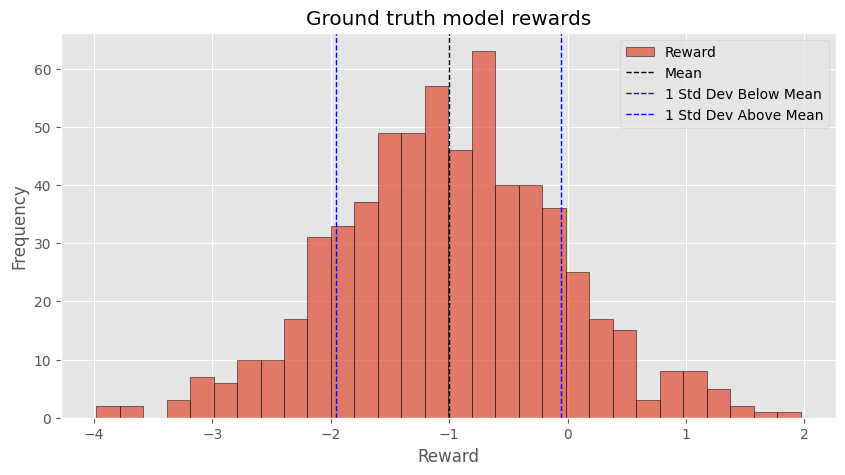

In [30]:
reward_arr = np.array(val_reward_list)

# Calculate mean and standard deviation
mean = np.mean(reward_arr)
std_dev = np.std(reward_arr)

# Calculate mean and standard deviation
mean = np.mean(reward_arr)
std_dev = np.std(reward_arr)

# Create the histogram
plt.figure(figsize=(10, 5))
plt.hist(reward_arr, bins=30, alpha=0.7, label='Reward', edgecolor='black')

# Add lines for the mean and one standard deviation above and below the mean
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev Below Mean')
plt.axvline(mean + std_dev, color='b', linestyle='dashed', linewidth=1, label='1 Std Dev Above Mean')

# Add labels and legend
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.title('Ground truth model rewards')
plt.grid(True)
plt.show()

print('Mean reward: ', mean)
print('Standard deviation of reward: ', std_dev)

# plt.savefig('../figures/system1-reward-histogram.png', dpi=300, bbox_inches = "tight")

## Reward of single batch of data

In [ ]:
# Load some data
feedback_data = df.to_numpy()

datamodule = model.get_datamodule(
    feedback_data=feedback_data,
    midi_root_dir='../',
    vae_module=None,
    batch_size=1, 
    num_workers=1, 
    pin_memory=True
)

datamodule.setup()

In [ ]:
dl = datamodule.train_dataloader()

In [42]:
batch = next(iter(dl))
file_0 = batch['file_0'][0]
file_1 = batch['file_1'][0]

In [43]:
# Check rows with recording_0=file_0 and recording_1=file_1
eda_df[(eda_df['Input.recording_0_url'].str.contains(file_0.replace('..//musicgpt-user-study/prompt-processed','').replace('.mid', '.mp3'))) & (eda_df['Input.recording_1_url'].str.contains(file_1.replace('..//musicgpt-user-study/prompt-processed','').replace('.mid', '.mp3')))]

,Input.recording_0_url,Input.recording_1_url,Answer.preference
246,https://p-lambda.github.io/musicgpt-user-study...,https://p-lambda.github.io/musicgpt-user-study...,1.0
247,https://p-lambda.github.io/musicgpt-user-study...,https://p-lambda.github.io/musicgpt-user-study...,1.0
248,https://p-lambda.github.io/musicgpt-user-study...,https://p-lambda.github.io/musicgpt-user-study...,1.0


In [46]:
# Check rows with recording_0=file_1 and recording_1=file_0
eda_df[(eda_df['Input.recording_1_url'].str.contains(file_0.replace('..//musicgpt-user-study/prompt-processed','').replace('.mid', '.mp3'))) & (eda_df['Input.recording_0_url'].str.contains(file_1.replace('..//musicgpt-user-study/prompt-processed','').replace('.mid', '.mp3')))]

,Input.recording_0_url,Input.recording_1_url,Answer.preference


In [44]:
x_0 = batch['input_ids_0']
bar_ids_0 = batch['bar_ids_0']
position_ids_0 = batch['position_ids_0']
x_1 = batch['input_ids_1']
bar_ids_1 = batch['bar_ids_1']
position_ids_1 = batch['position_ids_1']
preference = batch['preference']  

rewards_0 = model(x_0, bar_ids=bar_ids_0, position_ids=position_ids_0)
rewards_1 = model(x_1, bar_ids=bar_ids_1, position_ids=position_ids_1)

logits = rewards_1 - rewards_0

In [45]:
print('rewards_0: ' + str(rewards_0))
print('rewards_1: ' + str(rewards_1))
print('logits: ' + str(logits))
print('preference: ' + str(preference))
print('loss: ' + str(F.binary_cross_entropy_with_logits(logits, torch.unsqueeze(torch.Tensor(preference), 1), reduction='mean')))

rewards_0: tensor([[-3.4456]], grad_fn=<AddmmBackward>)
rewards_1: tensor([[-0.2622]], grad_fn=<AddmmBackward>)
logits: tensor([[3.1834]], grad_fn=<SubBackward0>)
preference: [1.0]
loss: tensor(0.0406, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


## Audit file-wise reward consistency

In [ ]:
# Load some data
feedback_data = df.to_numpy()

datamodule = model.get_datamodule(
    feedback_data=feedback_data,
    midi_root_dir='../',
    vae_module=None,
    batch_size=128, 
    num_workers=1, 
    pin_memory=True
)

datamodule.setup()

In [112]:
file_path = feedback_data[0][0]

In [115]:
def load_file(file):
  name = os.path.basename(file)
  
  try:
    rep = InputRepresentation(file, strict=True)
    events = rep.get_remi_events()
    description = rep.get_description()
  except Exception as err:
    raise ValueError(f'Unable to load file {file}') from err

  sample = {
    'events': events,
    'description': description
  }

  return sample

In [118]:
vocab = RemiVocab()
desc_vocab = DescriptionVocab()

In [119]:
def get_bars(events, include_ids=False):
    bars = [i for i, event in enumerate(events) if f"{BAR_KEY}_" in event]

    if include_ids:
        bar_ids = torch.bincount(torch.tensor(bars, dtype=torch.int), minlength=len(events))
        bar_ids = torch.cumsum(bar_ids, dim=0)

        return bars, bar_ids
    else:
        return bars

def get_positions(events):
    # Rewrite all bar keys with Position_0
    events = [f"{POSITION_KEY}_0" if f"{BAR_KEY}_" in event else event for event in events]
    # Get list of all position keys
    position_events = [event if f"{POSITION_KEY}_" in event else None for event in events]
    # Strip POSITION_KEY from position keys, and set every other key to None
    positions = [int(pos.split('_')[-1]) if pos is not None else None for pos in position_events]

    # Set first token to 0 if it is none
    if positions[0] is None:
        positions[0] = 0
    for i in range(1, len(positions)):
        if positions[i] is None:
            positions[i] = positions[i-1]
    positions = torch.tensor(positions, dtype=torch.int)

    return positions

def get_bos_eos_events(tuple_size=8):
    bos_event = torch.tensor(vocab.encode([BOS_TOKEN]), dtype=torch.long)
    eos_event = torch.tensor(vocab.encode([EOS_TOKEN]), dtype=torch.long)
    return bos_event, eos_event

In [ ]:
max_len = 

In [ ]:
try:
  current_file = load_file(file_path)
except ValueError as err:
  print("Error loading file")

events = current_file['events']

# Identify start of bars
bars, bar_ids = get_bars(events, include_ids=True)

# Identify positions
position_ids = get_positions(events)
# bug? max_pos = position_ids[-1]?
max_pos = position_ids.max()

# Encode tokens with appropriate vocabulary
event_ids = torch.tensor(vocab.encode(events), dtype=torch.long)

# Tokenize beginning of sentence, end of sentence keys
bos, eos = get_bos_eos_events()
zero = torch.tensor([0], dtype=torch.int)

event_ids = torch.cat([bos, event_ids, eos])
bar_ids = torch.cat([zero, bar_ids, zero])
position_ids = torch.cat([zero, position_ids, zero])

# Split up file into contexts of self.max_len
if self.max_len > 0:
  starts = list(range(0, len(event_ids), self.max_len+1))
  if len(starts) > 1:
    contexts = [(start, start + self.max_len+1) for start in starts[:-1]] + [(len(event_ids) - (self.max_len+1), len(event_ids))]
  elif len(starts) > 0:
    contexts = [(starts[0], self.max_len+1)]
else:
  contexts = [(0, len(event_ids))]

if self.max_contexts_per_file and self.max_contexts_per_file > 0:
  contexts = contexts[:self.max_contexts_per_file]

for start, end in contexts:
  # Add <bos> and <eos> to each context if contexts are limited to a certain number of bars
  if self.max_bars_per_context and self.max_bars_per_context > 0:
    src = torch.cat([bos, event_ids[start:end], eos])
    b_ids = torch.cat([zero, bar_ids[start:end], zero])
    p_ids = torch.cat([zero, position_ids[start:end], zero])
  else:
    src = event_ids[start:end]
    b_ids = bar_ids[start:end]
    p_ids = position_ids[start:end]

  if self.max_len > 0:
    src = src[:self.max_len + 1]

  x = {
    'input_ids': src,
    'file': os.path.basename(self.split[i]),
    'bar_ids': b_ids,
    'position_ids': p_ids,
  }

  yield x